In [1]:
from model import UNet
import torch
import torch.nn.functional as F
import torch.nn as nn
from skimage import io
import numpy as np
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline
torch.manual_seed(0)



In [2]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_shifted = image_tensor
    image_unflat = image_shifted.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=4)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()


criterion = nn.BCEWithLogitsLoss()
n_epochs = 20
input_dim = 1
label_dim = 1
display_step = 20
batch_size = 4
lr = 0.0002
initial_shape = 512
target_shape = 324
device = 'cuda'

def crop(image, new_shape):
    h_start = (image.shape[2] - new_shape[2]) // 2
    w_start = (image.shape[3] - new_shape[3]) // 2
    h_end = h_start + new_shape[2]
    w_end = w_start + new_shape[3]
    cropped_image = image[:,:, h_start:h_end, w_start:w_end]
    return cropped_image


volumes = torch.Tensor(io.imread('train-volume.tif'))[:, None, :, :] / 255
labels = torch.Tensor(io.imread('train-labels.tif', plugin="tifffile"))[:, None, :, :] / 255
labels = crop(labels, torch.Size([len(labels), 1, target_shape, target_shape]))
dataset = torch.utils.data.TensorDataset(volumes, labels)


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 0: Step 0: U-Net loss: 0.7161269783973694


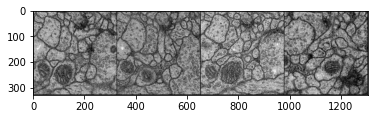

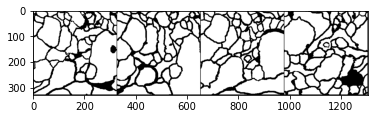

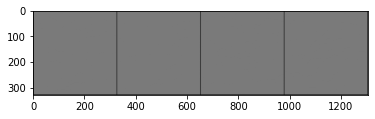

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 2: Step 20: U-Net loss: 0.5138014554977417


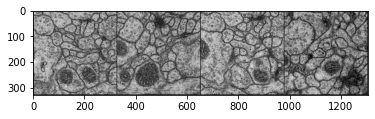

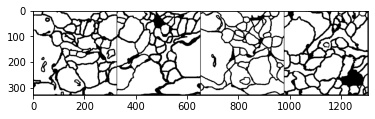

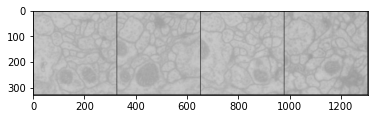

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5: Step 40: U-Net loss: 0.46406978368759155


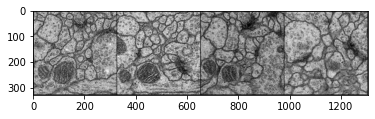

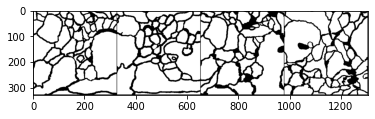

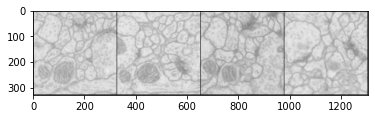

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 7: Step 60: U-Net loss: 0.3998509645462036


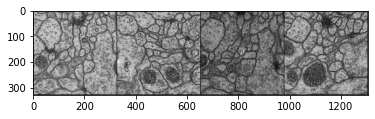

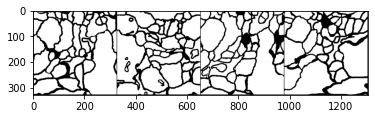

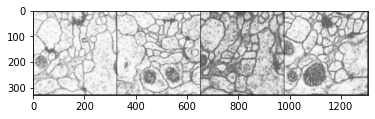

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 10: Step 80: U-Net loss: 0.42419999837875366


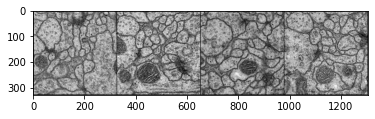

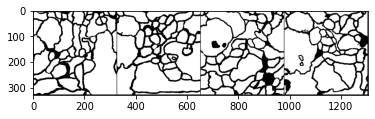

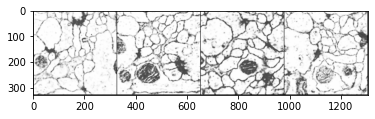

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 12: Step 100: U-Net loss: 0.32428163290023804


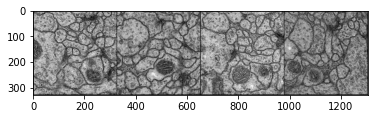

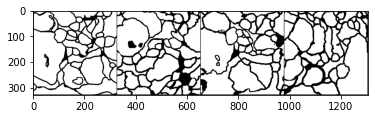

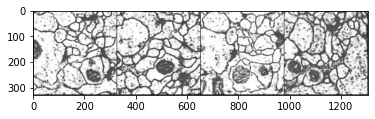

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 15: Step 120: U-Net loss: 0.324795126914978


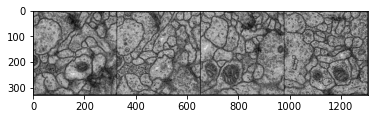

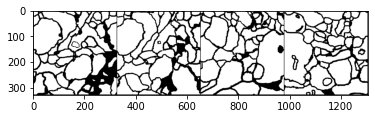

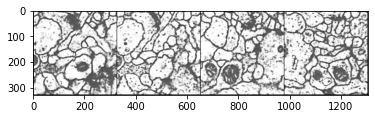

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 17: Step 140: U-Net loss: 0.32917964458465576


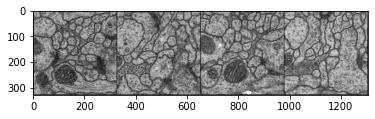

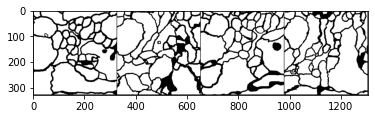

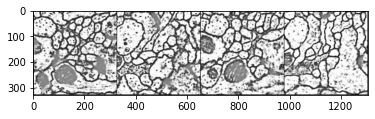

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [3]:
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True)

unet = UNet(input_dim, label_dim).to(device)
unet_opt = torch.optim.Adam(unet.parameters(), lr=lr)
cur_step = 0

for epoch in range(n_epochs):
    for real, labels in tqdm(dataloader):
        cur_batch_size = len(real)

        real = real.to(device)
        labels = labels.to(device)

        ### Update U-Net ###
        pred = unet(real)
        unet_loss = criterion(pred, labels)
        unet.zero_grad()
        unet_loss.backward()
        unet_opt.step()

        if cur_step % display_step == 0:
            print(f"Epoch {epoch}: Step {cur_step}: U-Net loss: {unet_loss.item()}")
            show_tensor_images(
                crop(real, torch.Size([len(real), 1, target_shape, target_shape])), 
                size=(input_dim, target_shape, target_shape)
            )
            show_tensor_images(labels, size=(label_dim, target_shape, target_shape))
            show_tensor_images(torch.sigmoid(pred), size=(label_dim, target_shape, target_shape))
        cur_step += 1